## SBC Data analysis

In [2]:
import sys
 
sys.path.insert(0, "../")

In [3]:
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd

data = pd.read_csv(r"./sbcdata.csv", header=0)
data_analysis = DataAnalysis(data, mimic_data = None)

/home/dwalke/git/graph_aware_ml/dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/graph_aware_ml/dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/graph_aware_ml/dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [4]:
data = pd.concat((data_analysis.get_training_data(), data_analysis.get_testing_data()))
max_Id = data["Id"].unique().max()
gw_data = data_analysis.get_gw_testing_data().copy(deep=True)
gw_data = gw_data.assign(Id=lambda x: x.Id + max_Id)
data = pd.concat((data, gw_data))
data = data.sort_values(["Id", "Time"])
data = data.reset_index(drop=True)
popped_index = data.pop("index")

In [5]:
from dataAnalysis.Constants import SEX_CATEGORY_COLUMN_NAME, SEX_COLUMN_NAME, FEATURES
data[SEX_CATEGORY_COLUMN_NAME] = data.loc[:, SEX_COLUMN_NAME] =="W"

data[SEX_CATEGORY_COLUMN_NAME] = data[SEX_CATEGORY_COLUMN_NAME].astype("int8")
data["Label"] = data["Label"] == "Sepsis"
data["Label"] = data["Label"].astype("int8")

## Edge index construction

In [6]:
import numpy as np
from tqdm.notebook import tqdm
import torch

def get_edge_index(dataset):
    dataset = dataset.reset_index(drop=True)
    source_edge_index = []
    target_edge_index = []

    for Id, group in dataset.groupby("Id"):
        indices = group.index
        offset = indices[0]
        num_nodes = len(indices)
        edge_index = torch.zeros((2, sum(range(num_nodes + 1))), dtype=torch.long)+offset

        ## Self edges
        edge_index[:, 0:num_nodes] = (torch.arange(num_nodes) + offset).view(1, -1)
        idx = num_nodes
        for i in range(1, num_nodes):
            edge_index[1, idx:idx + i] = i+offset
            edge_index[0, idx:idx + i] = torch.arange(i)+offset
            idx += i

        source_edge_index.extend(edge_index[0, :].numpy().tolist())
        target_edge_index.extend(edge_index[1, :].numpy().tolist())

    edge_index = np.asarray([np.asarray(source_edge_index), np.asarray(target_edge_index)])
    edge_index = torch.tensor(edge_index)
    return edge_index

In [7]:
test_edge_index = get_edge_index(data[(data["Set"] == "Validation") & (data["Center"] == "Leipzig")])
test_gw_edge_index = get_edge_index(data[(data["Set"] == "Validation") & (data["Center"] == "Greifswald")])
train_edge_index = get_edge_index(data[data["Set"] == "Training"])

In [8]:
from dataAnalysis.Constants import FEATURES, LABEL_COLUMN_NAME

train_mask = data["Set"] == "Training"
X_train = data.loc[train_mask, FEATURES].values
y_train = data.loc[train_mask, LABEL_COLUMN_NAME].values

test_mask = (data["Set"] == "Validation") & (data["Center"] == "Leipzig")
X_test = data.loc[test_mask, FEATURES].values
y_test = data.loc[test_mask, LABEL_COLUMN_NAME].values

test_gw_mask = (data["Set"] == "Validation") & (data["Center"] == "Greifswald")
X_test_gw = data.loc[test_gw_mask, FEATURES].values
y_test_gw = data.loc[test_gw_mask, LABEL_COLUMN_NAME].values

In [9]:
def reverse_edge_index(edge_index):
    rev_edge_index = torch.zeros_like(edge_index)
    index = torch.LongTensor([1,0])
    rev_edge_index[index] = edge_index
    return rev_edge_index

rev_train_edge_index = reverse_edge_index(train_edge_index)
rev_test_edge_index = reverse_edge_index(test_edge_index)
rev_test_gw_edge_index = reverse_edge_index(test_gw_edge_index)

In [9]:
from torch_geometric.utils import to_undirected
undir_train_edge_index = to_undirected(train_edge_index)
undir_test_edge_index = to_undirected(test_edge_index)
undir_test_gw_edge_index = to_undirected(test_gw_edge_index)

In [17]:
import numpy
def user_function(origin_features, updated_features, sum_neighbors, mul_neighbors, num_neighbors):
    return updated_features - sum_neighbors / num_neighbors

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

clf = random_forest = RandomForestClassifier(class_weight={0: 0.0025, 1: 1}, max_leaf_nodes=79,
                                             min_samples_leaf=0.0001,
                                             min_samples_split=0.0055,
                                             n_estimators=700, random_state=42, n_jobs=-1)
# XGBClassifier(tree_method='gpu_hist', 
#                            scale_pos_weight = 70,
#                            n_estimators=1000,
#                            max_depth=2,
#                            eta=0.1,
#                            min_child_weight = 7,
#                            max_delta_step= 7,
#                            sampling_method= "uniform")

clf_nh = random_forest = RandomForestClassifier(class_weight={0: 0.0025, 1: 1}, max_leaf_nodes=79,
                                                min_samples_leaf=0.0001,
                                                min_samples_split=0.0055,
                                                n_estimators=500, random_state=42, n_jobs=-1)

bst = XGBClassifier( tree_method='gpu_hist', 
                    n_estimators=1000,
                    max_depth=2,
                    eta=0.1,
                    min_child_weight = 7,
                    max_delta_step= 7,
                    sampling_method= "uniform")

bst_nh = XGBClassifier( tree_method='gpu_hist', 
                       n_estimators=1000,
                       max_depth=2,
                       eta=0.1,
                       min_child_weight = 7,
                       max_delta_step= 7,
                       sampling_method= "uniform")
feature_based_aggregation:Feature_based_aggregation = {
    "concat": True,
    "combined_clf": bst,
    'n_estimators':1
}

classifier_based_aggregation:Classifier_based_aggregation = {
    "clf_list": [clf, clf_nh],
    'n_estimators':1
}

In [18]:
framework = Framework("diff_of_updated_mean", hops=2, use_feature_based_aggregation = False,
          feature_based_aggregation = feature_based_aggregation,
            classifier_based_aggregation = classifier_based_aggregation, gpu_idx = 1, handle_nan = 0, normalize=False, use_pseudo_attention=False, cosine_eps = None)

framework.fit(X_train, rev_train_edge_index, y_train, None)

(RandomForestClassifier(class_weight={0: 0.0025, 1: 1}, max_leaf_nodes=79,
                        min_samples_leaf=0.0001, min_samples_split=0.0055,
                        n_estimators=700, n_jobs=-1, random_state=42),
 RandomForestClassifier(class_weight={0: 0.0025, 1: 1}, max_leaf_nodes=79,
                        min_samples_leaf=0.0001, min_samples_split=0.0055,
                        n_estimators=500, n_jobs=-1, random_state=42))

In [19]:
from sklearn.metrics import roc_auc_score,average_precision_score
y_score = framework.predict_proba(X_test, rev_test_edge_index, None)[:,1]
y_score_gw = framework.predict_proba(X_test_gw, rev_test_gw_edge_index, None)[:,1]

auroc = roc_auc_score(y_test, y_score)
auroc_gw = roc_auc_score(y_test_gw, y_score_gw)

auc_precision_recall = average_precision_score(y_test, y_score)
auc_precision_recall_gw = average_precision_score(y_test_gw, y_score_gw)

pd.DataFrame([[auroc, auc_precision_recall], [auroc_gw, auc_precision_recall_gw]], columns=["AUROC", "AUPRC"], index=["L", "GW"])

,AUROC,AUPRC
L,0.945359,0.051880
GW,0.943195,0.030419


In [15]:
from sklearn.model_selection import GridSearchCV
def get_best_estimator(model, param_grid):
    grid = GridSearchCV(
    n_jobs=-1,
    cv=3,
    estimator=model,
    scoring=['accuracy'],
    refit="accuracy",
    return_train_score=True,
    param_grid=param_grid,
    verbose= 10
    )
    grid.fit(X_train, rev_train_edge_index, y_train, None)
    return grid.best_estimator_

param_grid={
        'n_estimators': range(200, 800, 100),
}
framework.grid_search(X_train, rev_train_edge_index, y_train, None, [param_grid], n_jobs=-1,
    cv=3,
    scoring=['accuracy'],
    refit="accuracy",
    return_train_score=True,
    verbose= 10
)

Exception: You need to provide two grid parameter, one for each classifier!

## Framework

In [1]:
import torch
from sklearn.base import BaseEstimator
from typing import TypedDict
import numpy 
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV

class Feature_based_aggregation(TypedDict):
    """
    A class for giving type hints for the dict feature_based_aggregation.
    
    Attributes
    ----------
    concat:bool
        A boolean whether to concat or add target node features and neighborhood features
    combined_clf: BaseEstimator
        A classifier (combined_clf) from sklearn applied to the aggregated features 
        (target node features and neighborhood features)
    """
    combined_clf: BaseEstimator
    concat: bool
    n_estimators: int ## rather list of classifiers??
        
class Classifier_based_aggregation(TypedDict):
    """
    A class for giving type hints for the dict classifier_based_aggregation.
    
    Attributes
    ----------
    clf_list: tuple[BaseEstimator, BaseEstimator]
        A tuple classifiers from sklearn - one applied to the target node features 
        and the other one to the neighborhood features
    """
    clf_list: tuple[BaseEstimator, BaseEstimator]
    n_estimators: int ## other data structure?,
    weights: tuple[float, float]
    #weight: float weights influence of self-awareness to neighborhood-awareness

USER_FUNCTIONS = {
    'sum': lambda origin_features, updated_features, sum_neighbors, mul_neighbors, num_neighbors, hop: sum_neighbors,
    'mean': lambda origin_features, updated_features, sum_neighbors, mul_neighbors, num_neighbors, hop: sum_neighbors / num_neighbors,
    'diff_of_origin_mean': lambda origin_features, updated_features, sum_neighbors, mul_neighbors, num_neighbors, hop: origin_features - sum_neighbors / num_neighbors,
    'diff_of_updated_mean': lambda origin_features, updated_features, sum_neighbors, mul_neighbors, num_neighbors, hop: updated_features - sum_neighbors / num_neighbors,
    'sum_of_origin_mean': lambda origin_features, updated_features, sum_neighbors, mul_neighbors, num_neighbors, hop: origin_features + sum_neighbors / num_neighbors,
    'sum_of_updated_mean': lambda origin_features, updated_features, sum_neighbors, mul_neighbors, num_neighbors, hop: updated_features + sum_neighbors / num_neighbors,
}

## Verbesserungsvorschläge? -> besonders um Acc zu verbessern
## heterogene Graphen?
##TODO More input_validation, grid search method whoch accepts the same params
class Framework:
    """
    A class for giving Machine learning algorithms additional graph-awareness.

    Attributes
    ----------
    user_function:def|str
        a user-defined function applied to the aggregation of neighboring nodes or a string from USER_FUNCTIONS
    hops:int
        number of hops to aggregate
    use_feature_based_aggregation:bool
        Boolean whether to use feature-based aggregation or classifier-based aggregation
    feature_based_aggregation:Feature_based_aggregation
        dictionary containing a classifier (combined_clf) applied to the aggregated features
        and a boolean (concat) indicating whether to concat or add up features from ttarget-nodes and it's neighbors
    classifier_based_aggregation:Classifier_based_aggregation
        dictionary containing a tuple of classifiers (clf_list), one applied to the features of the target node
        and the other one to the features of the aggregated features of the neighbors
    gpu_idx:int|None=None
        Optional index parameter for using GPU device (None or an integer like 0 depending the GPU index)
    handle_nan:float|None|int=None
        Optional parameter whether to handle nan values after applying the user-defined function (e.g., dividing by 0)
        Replaces all nan values with the given value
    normalize:bool=True (BETA)
        Optional boolean whether or not to normalize features? 
    use_pseudo_attention = True (BETA)
        Optional boolean whether or not to apply a pseudo attention mechanism 
        (weighted aggregation based on cosine-similarity)
    device:torch.DeviceObjType
        Torch device for computation (cpu) or gpu if available and requested

    Methods
    -------
    make_tensors()
        Checks correct type and format of input features and edge_index
        And transfers possible numby arrays to torch tensors
    """
    
    ## min max aggregation might also work as future idea (https://pytorch.org/docs/stable/generated/torch.Tensor.scatter_reduce_.html) -> in Beta

    def __init__(self, user_function, 
                 hops:int,
                 use_feature_based_aggregation:bool,
                 feature_based_aggregation:Feature_based_aggregation,
                 classifier_based_aggregation:Classifier_based_aggregation,
                 gpu_idx:int|None=None,
                 handle_nan:float|None=None,
                 normalize:bool=False,
                 use_pseudo_attention = False,
                 cosine_eps:float|None=None,
                dropout_attn:float|None = None) -> None:
        self.user_function = user_function
        self.hops:int = hops
        self.use_feature_based_aggregation:bool = use_feature_based_aggregation
        self.feature_based_aggregation:Feature_based_aggregation = feature_based_aggregation
        self.classifier_based_aggregation:Classifier_based_aggregation = classifier_based_aggregation
        self.gpu_idx:int|None = gpu_idx
        self.handle_nan:float|int|None = handle_nan
        self.normalize:bool = normalize
        self.use_pseudo_attention:bool = use_pseudo_attention
        self.cosine_eps:float|None = cosine_eps
        self.dropout_attn:float|None = dropout_attn
        self.device:torch.DeviceObjType = torch.device(f"cuda:{str(self.gpu_idx)}") if self.gpu_idx is not None and torch.cuda.is_available() else torch.device("cpu")
    
    def update_user_function(self):
        if self.user_function in USER_FUNCTIONS:
            self.user_function = USER_FUNCTIONS[self.user_function]
        else:
            raise Exception(f"Only the following string values are valid inputs for the user function: {[key for key in USER_FUNCTIONS]}. You can also specify your own function for aggregatioon.")
    def get_features(self,
                     X:torch.FloatTensor|numpy._typing.NDArray,
                     edge_index:torch.LongTensor|numpy._typing.NDArray,
                     mask:torch.BoolTensor|numpy._typing.NDArray,
                    is_training:bool = False) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        if mask is None:
            mask = torch.ones(X.shape[0]).type(torch.bool)
        if isinstance(self.user_function, str):
            self.update_user_function()
        ## To tensor
        X = Framework.get_feature_tensor(X)
        edge_index = Framework.get_edge_index_tensor(edge_index)
        mask = Framework.get_mask_tensor(mask)
        
        ## To device
        X = self.shift_tensor_to_device(X)
        edge_index = self.shift_tensor_to_device(edge_index)
        mask = self.shift_tensor_to_device(mask)
        
        if self.hops <= 0:
            return (X[mask], None)
        
        ## Aggregate
        neighbor_features = self.aggregate(X, edge_index, is_training)
        
        return (X[mask], neighbor_features[mask])
    
    def fit(self,
            X_train:torch.FloatTensor|numpy._typing.NDArray,
            edge_index:torch.LongTensor|numpy._typing.NDArray,
            y_train:torch.LongTensor|numpy._typing.NDArray,
            train_mask:torch.BoolTensor|numpy._typing.NDArray|None,
            kwargs_list = None
            ) -> BaseEstimator:   
        if train_mask is None:
            train_mask = torch.ones(X_train.shape[0]).type(torch.bool)
        y_train = Framework.get_label_tensor(y_train)
        y_train = y_train[train_mask]
        
        self.validate_input()
        
        X_train, neighbors = self.get_features(X_train, edge_index, train_mask, True)        
        
        if self.use_feature_based_aggregation and self.feature_based_aggregation is not None:
            concat:bool = self.feature_based_aggregation["concat"]
            clf:BaseEstimator = self.feature_based_aggregation["combined_clf"]
            out_clfs:list[BaseEstimator] = []
            if neighbors is not None:
                X_train:torch.FloatTensor = torch.concat((X_train, neighbors), dim = 1) if concat else torch.add(X_train, neighbors)
            for i in range(self.feature_based_aggregation["n_estimators"]):
                clf_clone = clone(clf)
                if kwargs_list and len(kwargs_list) == 1:
                    clf_clone.fit(X_train.cpu().numpy(), y_train,**kwargs_list[0])
                else:
                    clf_clone.fit(X_train.cpu().numpy(), y_train)
                out_clfs.append(clf_clone)
            self.feature_based_aggregation["trained_clfs"] = out_clfs
            return self.feature_based_aggregation["trained_clfs"][0] if len(self.feature_based_aggregation["trained_clfs"]) == 1 else self.feature_based_aggregation["trained_clf"]
        
        if not self.use_feature_based_aggregation and self.classifier_based_aggregation is not None:
            clf_list:list[BaseEstimator] = self.classifier_based_aggregation["clf_list"]
            out_clfs:list[tuple[BaseEstimator]] = []
            for i in range(self.classifier_based_aggregation["n_estimators"]):
                clf_0_clone = clone(clf_list[0])
                clf_1_clone = clone(clf_list[1])          
                if kwargs_list and len(kwargs_list) >= 1:
                    clf_0_clone.fit(X_train.cpu().numpy(), y_train,**kwargs_list[0])
                else:
                    clf_0_clone.fit(X_train.cpu().numpy(), y_train)
                if neighbors is not None:
                    if kwargs_list and len(kwargs_list) >= 1:
                        clf_1_clone.fit(neighbors.cpu().numpy(), y_train,**kwargs_list[1])
                    else:
                        clf_1_clone.fit(neighbors.cpu().numpy(), y_train)
                out_clfs.append((clf_0_clone, clf_1_clone))
            self.classifier_based_aggregation["trained_clfs"] = out_clfs
            return self.classifier_based_aggregation["trained_clfs"][0] if len(self.classifier_based_aggregation["trained_clfs"]) == 1 else self.classifier_based_aggregation["trained_clfs"]
    
    def predict_proba(self, X_test:torch.FloatTensor|numpy._typing.NDArray,
                      edge_index:torch.LongTensor|numpy._typing.NDArray,
                      test_mask:torch.BoolTensor|numpy._typing.NDArray|None,
                     **kwargs):  
        if test_mask is None:
            test_mask = torch.ones(X_test.shape[0]).type(torch.bool)
        X_test, neighbors = self.get_features(X_test, edge_index, test_mask)
        
        if self.use_feature_based_aggregation and self.feature_based_aggregation is not None:
            concat:bool = self.feature_based_aggregation["concat"]
#             clf:BaseEstimator = self.feature_based_aggregation["combined_clf"]
            if neighbors is not None:
                X_test:torch.FloatTensor = torch.concat((X_test, neighbors), dim = 1) if concat else torch.add(X_test, neighbors)
            pred_proba = []
            for clf in self.feature_based_aggregation["trained_clfs"]:
                pred_proba.append(clf.predict_proba(X_test.cpu().numpy(),**kwargs))
            return np.mean(np.array(pred_proba), axis=0)
        
        if not self.use_feature_based_aggregation and self.classifier_based_aggregation is not None:
#             clf_list:list[BaseEstimator] = self.classifier_based_aggregation["clf_list"]
            pred_proba = []
            for clf_list in self.classifier_based_aggregation["trained_clfs"]:
                pred_proba_0 = clf_list[0].predict_proba(X_test.cpu().numpy(),**kwargs) 
                if "weights" not in classifier_based_aggregation or len(classifier_based_aggregation["weights"]) != 2:
                    classifier_based_aggregation["weights"] = (.5, .5)
                pred_proba.append(classifier_based_aggregation["weights"][0] * pred_proba_0)
                if neighbors is not None:
                    pred_proba_1 = clf_list[1].predict_proba(neighbors.cpu().numpy(), **kwargs)
                    pred_proba.append(classifier_based_aggregation["weights"][1] * pred_proba_1)     
            return np.mean(np.array(pred_proba), axis=0)
        
    
    def predict(self,
                X_test:torch.FloatTensor|numpy._typing.NDArray,
                edge_index:torch.LongTensor|numpy._typing.NDArray,
                test_mask:torch.BoolTensor|numpy._typing.NDArray|None, **kwargs):
        return self.predict_proba(X_test, edge_index, test_mask, **kwargs).argmax(1)
        

    def validate_input(self):
        pass
            
    @staticmethod
    def get_feature_tensor(X:torch.FloatTensor|numpy._typing.NDArray) -> torch.FloatTensor|None:
        if not torch.is_tensor(X):
            try:
                return torch.from_numpy(X).type(torch.float)
            except:
                raise Exception("Features input X must be numpy array or torch tensor!")
                return None 
        return X
    
    @staticmethod
    def get_label_tensor(y:torch.LongTensor|numpy._typing.NDArray) -> torch.LongTensor|None:
        if not torch.is_tensor(y):
            try:
                return torch.from_numpy(y).type(torch.long)
            except:
                raise Exception("Label input y must be numpy array or torch tensor!")
                return None
        return y
    
    @staticmethod
    def get_mask_tensor(mask:torch.BoolTensor|numpy._typing.NDArray) -> torch.BoolTensor|None:
        if not torch.is_tensor(mask):
            try:
                return torch.from_numpy(mask).type(torch.bool)
            except:
                raise Exception("Input mask must be numpy array or torch tensor!")
                return None
        return mask
            
    @staticmethod
    def get_edge_index_tensor(edge_index:torch.LongTensor|numpy._typing.NDArray) -> torch.LongTensor|None:
        if not torch.is_tensor(edge_index):
            try:
                edge_index =  torch.from_numpy(edge_index).type(torch.long)
                Framework.validate_edge_index(edge_index)
                return edge_index
            except:
                raise Exception("Edge index must be numpy array or torch tensor")
                return None
        return edge_index
    
    @staticmethod
    def validate_edge_index(edge_index:torch.LongTensor) -> None:
        if edge_index.shape[0] != 2:
            raise Exception("Edge index must have the shape 2 x NumberOfEdges")
            # TODO: check max edge index and shape of features
            
    def apply_attention_mechanism(self, source_lift:torch.FloatTensor,
                                  features_for_aggregation:torch.FloatTensor,
                                  target:torch.LongTensor,
                                 is_training:bool = False) -> torch.FloatTensor:
        cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
        score = cos(source_lift, features_for_aggregation.index_select(0, target))
        dropout_tens = None
        
        origin_scores = torch.clone(score)
        if self.cosine_eps:
            score[score < self.cosine_eps] = -torch.inf
        if self.dropout_attn is not None and is_training:
            dropout_tens = torch.FloatTensor(score.shape[0]).uniform_(0, 1)
            score[dropout_tens < self.dropout_attn] = -torch.inf
            print(origin_scores[dropout_tens < self.dropout_attn])
        exp_score = torch.exp(score)
        summed_exp_score = torch.zeros_like(exp_score).scatter(0, target,exp_score, reduce="add")
        target_lifted_summed_exp_score = summed_exp_score.index_select(0, target)
        normalized_scores = exp_score / target_lifted_summed_exp_score
        source_lift = normalized_scores.unsqueeze(1) * source_lift
        return source_lift
    
    def shift_tensor_to_device(self,
                               t:torch.FloatTensor) -> torch.FloatTensor:
        if self.gpu_idx is not None:
            return t.to(self.device) 
        return t
    
    
    def aggregate(self, X:torch.FloatTensor, edge_index:torch.LongTensor, is_training:bool=False) -> torch.FloatTensor: 
        features_for_aggregation:torch.FloatTensor = torch.clone(X)
        for i in range(self.hops):
            if self.normalize:
                features_for_aggregation = torch.nn.functional.normalize(features_for_aggregation, dim = 0)
            source_lift = features_for_aggregation.index_select(0, edge_index[0])
            target = edge_index[1]
            
            if self.use_pseudo_attention:
                source_lift = self.apply_attention_mechanism(source_lift, features_for_aggregation, target, is_training)
            
            summed_neighbors = torch.zeros_like(features_for_aggregation, device=self.device).scatter_(0, target.unsqueeze(0).repeat(features_for_aggregation.shape[1], 1).t(), source_lift, reduce="add")
            multiplied_neighbors = torch.ones_like(features_for_aggregation, device=self.device).scatter_(0, target.unsqueeze(0).repeat(features_for_aggregation.shape[1], 1).t(), source_lift, reduce="multiply")

            num_source_neighbors = torch.zeros(features_for_aggregation.shape[0], dtype=torch.float, device=self.device)
            num_source_neighbors.scatter_(0, target, torch.ones_like(target, dtype=torch.float, device=self.device), reduce="add")
            num_source_neighbors = num_source_neighbors.unsqueeze(-1)

            out = self.user_function(X,features_for_aggregation,
                                     summed_neighbors, multiplied_neighbors, num_source_neighbors, i)
            
            if self.handle_nan is not None:
                out = torch.nan_to_num(out, nan=self.handle_nan)
            features_for_aggregation = out
        return features_for_aggregation
    
    def validate_grid_input(self, grid_params):
        if len(grid_params) != 1 and self.use_feature_based_aggregation:
            raise Exception("You need to provide grid parameter for the classifier!")
        if len(grid_params) != 2 and not self.use_feature_based_aggregation:
            raise Exception("You need to provide two grid parameter, one for each classifier!")
        return
    
    def grid_search(self,
            X_train:torch.FloatTensor|numpy._typing.NDArray,
            edge_index:torch.LongTensor|numpy._typing.NDArray,
            y_train:torch.LongTensor|numpy._typing.NDArray,
            train_mask:torch.BoolTensor|numpy._typing.NDArray|None,
            grid_params:list,
            **grid_kwargs
            ) -> BaseEstimator:        
        if train_mask is None:
            train_mask = torch.ones(X_train.shape[0]).type(torch.bool)
        y_train = Framework.get_label_tensor(y_train)
        y_train = y_train[train_mask]
        
        self.validate_grid_input(grid_params)
        
        X_train, neighbors = self.get_features(X_train, edge_index, train_mask)        
        
        if self.use_feature_based_aggregation and self.feature_based_aggregation is not None:
            concat:bool = self.feature_based_aggregation["concat"]
            clf:BaseEstimator = self.feature_based_aggregation["combined_clf"]
            if neighbors is not None:
                X_train:torch.FloatTensor = torch.concat((X_train, neighbors), dim = 1) if concat else torch.add(X_train, neighbors)
            grid = GridSearchCV(
                estimator=clf,
                param_grid=grid_params[0],
                **grid_kwargs
            )
            grid.fit(X_train.cpu().numpy(), y_train)
            self.feature_based_aggregation["combined_clf"] = grid.best_estimator_
            return self.feature_based_aggregation["combined_clf"]
        
        if not self.use_feature_based_aggregation and self.classifier_based_aggregation is not None:
            clf_list:list[BaseEstimator] = self.classifier_based_aggregation["clf_list"]
            optimzed_clfs = []
            grid_self = GridSearchCV(
                estimator=clf_list[0],
                param_grid=grid_params[0],
                **grid_kwargs
            )
            grid_self.fit(X_train.cpu().numpy(), y_train)
            optimzed_clfs.append(grid_self.best_estimator_)
            if neighbors is not None:
                grid_neighbors = GridSearchCV(
                    estimator=clf_list[1],
                    param_grid=grid_params[1],
                    **grid_kwargs
                )
                grid_neighbors.fit(neighbors.cpu().numpy(), y_train)
                optimzed_clfs.append(grid_neighbors.best_estimator_)
            self.classifier_based_aggregation["clf_list"] = optimzed_clfs
            return self.classifier_based_aggregation["clf_list"]

In [123]:
from xgboost import XGBClassifier
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import add_self_loops
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC

dataset = Planetoid(root='/tmp/Cora', name='Cora', split="public") ## public
dataset.transform = T.NormalizeFeatures()

PSEUDO_EPOCHS = 1

X =  dataset[0].x #node_features #dataset[0].x.repeat(PSEUDO_EPOCHS, 1) #node_features #dataset[0].x.repeat(PSEUDO_EPOCHS, 1)
y =  dataset[0].y #node_labels #dataset[0].y.repeat(PSEUDO_EPOCHS) #node_labels #dataset[0].y.repeat(PSEUDO_EPOCHS)

test =  dataset[0].test_mask #test_indices #dataset[0].test_mask #test_indices #dataset[0].test_mask.repeat(PSEUDO_EPOCHS)
# test[dataset[0].y.shape[0]:] = False
# print(test.sum())
train = dataset[0].train_mask #train_indices #dataset[0].train_mask #train_indices #dataset[0].train_mask.repeat(PSEUDO_EPOCHS)
val =  dataset[0].val_mask


# X = dataset[0].x
# y = dataset[0].y

# test = dataset[0].test_mask
# train = ~test #dataset[0].train_mask
# val = dataset[0].val_mask

# y_train = y[train]
# y_test = y[test]

edge_index = dataset[0].edge_index 
edge_index = add_self_loops(edge_index)[0]

# edges_indices = []
# for i in range(PSEUDO_EPOCHS):
#     edges_indices.append(dataset[0].edge_index+i*dataset[0].x.shape[0])
# edge_index = torch.cat(edges_indices, 1)

bst = XGBClassifier( tree_method='gpu_hist', 
                           n_estimators=1100,
                           max_depth=2,
                    random_state=42,
                    eta=0.3,
                    reg_lambda=0.001,
                           min_child_weight = 1,
                           max_delta_step= 3,
                           sampling_method= "uniform")
   
bst_nh = XGBClassifier( tree_method='gpu_hist', 
                           n_estimators=900,
                           max_depth=2,
                       random_state=42,
                       reg_lambda=0.2953684210526316,
                       eta=0.2733333333333333,
                           min_child_weight = 2,
                           max_delta_step= 4,
                           sampling_method= "uniform",
                      subsample=0.5)

# bst = SGDClassifier(random_state=42, loss="log_loss", eta0=1, learning_rate="constant", penalty="l2", alpha=0.0002) # XGBClassifier(booster="gblinear") #RandomForestClassifier()
   
# bst_nh = SGDClassifier(random_state=42, loss="log_loss", eta0=1, learning_rate="constant", penalty="l2", alpha=0.0002) #XGBClassifier(booster="gblinear") #RandomForestClassifier()

# bst = SVC(probability=True, C=100, kernel="linear", degree=1)
   
# bst_nh = SVC(probability=True, C=100, kernel="linear", degree=1)

feature_based_aggregation:Feature_based_aggregation = {
    "concat": True,
    "combined_clf": clf,
    "n_estimators": 1,
    
}
weight = .5 #0.475
classifier_based_aggregation:Classifier_based_aggregation = {
    "clf_list": [bst, bst_nh],
    "n_estimators": 1,
    "weights": [weight, 1-weight]
}

In [126]:
import numpy
import time
def user_function(origin_features, updated_features, sum_neighbors, mul_neighbors, num_neighbors, hop):
    return  updated_features + sum_neighbors #/ torch.max(sum_neighbors, 0)[0]

framework_xgb = Framework(user_function, hops=3, use_feature_based_aggregation = False,
              feature_based_aggregation = feature_based_aggregation,
                classifier_based_aggregation = classifier_based_aggregation, gpu_idx = 1, handle_nan = 0, normalize=True, use_pseudo_attention=True,
                    cosine_eps = .01 , dropout_attn=None)

start = time.time()
self_val, neighbors_val = framework_xgb.get_features(X, edge_index,val)
self_val, neighbors_val = self_val.cpu(), neighbors_val.cpu()
kwargs_list=[{
    "eval_set":[(self_val, y[val])], "early_stopping_rounds":3
}, {"eval_set":[(neighbors_val, y[val])], "early_stopping_rounds":3}]
framework_xgb.fit(X, edge_index, y, train, kwargs_list=kwargs_list) #, kwargs_list=kwargs_list
print(time.time() - start)

[0]	validation_0-mlogloss:1.73400
[1]	validation_0-mlogloss:1.63995
[2]	validation_0-mlogloss:1.54837
[3]	validation_0-mlogloss:1.48037
[4]	validation_0-mlogloss:1.45511
[5]	validation_0-mlogloss:1.42616
[6]	validation_0-mlogloss:1.40100
[7]	validation_0-mlogloss:1.37746
[8]	validation_0-mlogloss:1.37575
[9]	validation_0-mlogloss:1.36987
[10]	validation_0-mlogloss:1.36355
[11]	validation_0-mlogloss:1.35918
[12]	validation_0-mlogloss:1.34453
[13]	validation_0-mlogloss:1.34202
[14]	validation_0-mlogloss:1.33372
[15]	validation_0-mlogloss:1.33217
[16]	validation_0-mlogloss:1.32909
[17]	validation_0-mlogloss:1.32382
[18]	validation_0-mlogloss:1.32752


/home/dwalke/.local/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:19:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[19]	validation_0-mlogloss:1.32067
[20]	validation_0-mlogloss:1.31594
[21]	validation_0-mlogloss:1.32297
[22]	validation_0-mlogloss:1.32562
[0]	validation_0-mlogloss:1.66496
[1]	validation_0-mlogloss:1.47006
[2]	validation_0-mlogloss:1.35592
[3]	validation_0-mlogloss:1.25656
[4]	validation_0-mlogloss:1.16575
[5]	validation_0-mlogloss:1.10393
[6]	validation_0-mlogloss:1.04138
[7]	validation_0-mlogloss:0.99219
[8]	validation_0-mlogloss:0.94844
[9]	validation_0-mlogloss:0.89773
[10]	validation_0-mlogloss:0.87204
[11]	validation_0-mlogloss:0.85190
[12]	validation_0-mlogloss:0.82722
[13]	validation_0-mlogloss:0.82055
[14]	validation_0-mlogloss:0.80748
[15]	validation_0-mlogloss:0.79850
[16]	validation_0-mlogloss:0.79455
[17]	validation_0-mlogloss:0.79733


/home/dwalke/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:19:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[18]	validation_0-mlogloss:0.78743
[19]	validation_0-mlogloss:0.78669
[20]	validation_0-mlogloss:0.76802
[21]	validation_0-mlogloss:0.76707
[22]	validation_0-mlogloss:0.76692
[23]	validation_0-mlogloss:0.76274
[24]	validation_0-mlogloss:0.76288
[25]	validation_0-mlogloss:0.75665
[26]	validation_0-mlogloss:0.75304
[27]	validation_0-mlogloss:0.74388
[28]	validation_0-mlogloss:0.73596
[29]	validation_0-mlogloss:0.73232
[30]	validation_0-mlogloss:0.73394
[31]	validation_0-mlogloss:0.73615
[32]	validation_0-mlogloss:0.73575
1.5777363777160645


In [127]:
import numpy as np
from sklearn.metrics import accuracy_score
pred = framework_xgb.predict(X, edge_index, test) 
pred_val = framework_xgb.predict(X, edge_index, val) 
y_test = y[test]
y_val = y[val]
print(accuracy_score(y_val, pred_val))
print(accuracy_score(y_test, pred))

/home/dwalke/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:19:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


0.78
0.808


In [113]:
bst = SVC(probability=True, C=.7, kernel="linear", degree=1)
   
bst_nh = SVC(probability=True, C=.7, kernel="linear", degree=1)

feature_based_aggregation:Feature_based_aggregation = {
    "concat": True,
    "combined_clf": clf,
    "n_estimators": 1,
    
}
weight = .5 #0.475
classifier_based_aggregation:Classifier_based_aggregation = {
    "clf_list": [bst, bst_nh],
    "n_estimators": 1,
    "weights": [weight, 1-weight]
}

framework_svc = Framework(user_function, hops=3, use_feature_based_aggregation = False,
              feature_based_aggregation = feature_based_aggregation,
                classifier_based_aggregation = classifier_based_aggregation, gpu_idx = 1, handle_nan = 0, normalize=True, use_pseudo_attention=True,
                    cosine_eps = .01 , dropout_attn=None)

start = time.time()
framework_svc.fit(X, edge_index, y, train) 
print(time.time() - start)

import numpy as np
from sklearn.metrics import accuracy_score
pred = framework_svc.predict(X, edge_index, test) 
pred_val = framework_svc.predict(X, edge_index, val) 
y_test = y[test]
y_val = y[val]
print(accuracy_score(y_val, pred_val))
print(accuracy_score(y_test, pred))

0.2784135341644287
0.726
0.698


In [80]:
pred_val = (framework_svc.predict_proba(X, edge_index, val) +  framework_xgb.predict_proba(X, edge_index, val)).argmax(1)
print(accuracy_score(y_val, pred_val))
pred = (.4*framework_svc.predict_proba(X, edge_index, test) +  .6*framework_xgb.predict_proba(X, edge_index, test)).argmax(1)
print(accuracy_score(y_test, pred))

0.798
0.826


## Partial dependence

In [154]:
clf = framework.fit(X_train, rev_train_edge_index, y_train, None)

/home/dwalke/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:45:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [178]:
features = framework.get_features(X_train, rev_train_edge_index,None)
features = list(map(lambda f: f.cpu(), features))
X_sbc = np.concatenate(features, axis=1)

In [172]:
features.shape

(1015074, 14)

[(0, 2)]
['Features #0', 'Features #1', 'Features #2', 'Features #3', 'Features #4', 'Features #5', 'Features #6', 'Features #7', 'Features #8', 'Features #9', 'Features #10', 'Features #11', 'Features #12', 'Features #13']


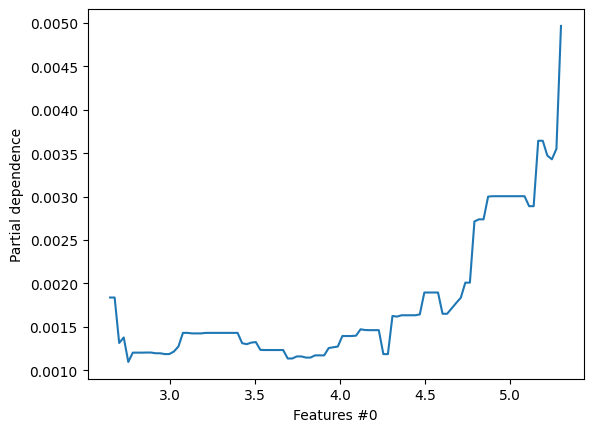

In [188]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

# clf = framework.fit(X_train, rev_train_edge_index, y_train, None)[0]#GradientBoostingRegressor(n_estimators=10).fit(X, y)
features, feature_names = [(0,2)], [f"Features #{i}" for i in range(X_sbc.shape[1])]
print(features)
print(feature_names)
deciles = {2: np.linspace(0, 1, num=5)}
pd_results = partial_dependence(
    clf, X_sbc, features=4, kind="average", grid_resolution=100)
display = PartialDependenceDisplay(
    [pd_results], features=features, feature_names=feature_names,
    target_idx=0, deciles=deciles
)
display.plot()
plt.show()

## Hyperopt

In [22]:
framework = Framework(user_function, hops=3, use_feature_based_aggregation = False,
              feature_based_aggregation = feature_based_aggregation,
                classifier_based_aggregation = classifier_based_aggregation, gpu_idx = 1, handle_nan = 0, normalize=True, use_pseudo_attention=True,
                    cosine_eps = .01 , dropout_attn=None)

self_val, neighbors_val = framework.get_features(X, edge_index,val)
self_val, neighbors_val = self_val.cpu(), neighbors_val.cpu()
self_train, neighbors_train = framework.get_features(X, edge_index,train)
self_train, neighbors_train = self_train.cpu(), neighbors_train.cpu()

self_test, neighbors_test = framework.get_features(X, edge_index,test)
self_test, neighbors_test = self_test.cpu(), neighbors_test.cpu()

X_train_self = self_train
X_train_neigh = neighbors_train
y_train = y[train]
X_val_self = self_val
X_val_neigh = neighbors_val
y_val = y[val]
X_test_self = self_test
X_test_neigh = neighbors_test
y_test = y[test]

In [19]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp,STATUS_OK
from sklearn.metrics import accuracy_score

booster_self = ["gbtree", "dart"]
booster_neigh = ["gbtree",  "dart"]

n_estimators_self = [5, 50, 65, 70, 75, 80, 90, 100,110, 120, 150, 200, 400]
n_estimators_neigh = [5, 50, 75, 100, 125, 150,160,170, 175,180, 200]

max_depth_self = [None, 1, 2, 3, 4, 8]
max_depth_neigh = [None,2, 3, 4, 5,6,7,8,9,10]

max_delta_step_self = [None, 1, 2, 3, 4, 8]
max_delta_step_neigh = [None, 1, 2, 3, 4, 8]

min_child_weight_self = [None, 1, 2, 3, 4, 8]
min_child_weight_neigh = [None, 1, 2, 3, 4, 8]
# Define the hyperparameter space
space_self = {
    'booster': hp.choice('booster',booster_self),
    'n_estimators': hp.choice('n_estimators',n_estimators_self),
    'max_depth': hp.choice('max_depth',max_depth_self),
    'eta': hp.loguniform('eta', -5, -1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'max_delta_step': hp.choice('max_delta_step',max_delta_step_self),
    'min_child_weight': hp.choice('min_child_weight',min_child_weight_self),
    'reg_lambda': hp.uniform('reg_lambda', 0.02, 0.1),
    'alpha': hp.uniform('alpha', 0, 0.1),
   'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.7, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.7, 1.0),
    'rate_drop': hp.uniform('rate_drop', 0.0, 1.0),
    'skip_drop': hp.uniform('skip_drop', 0.0, 1.0),
}

space_neigh = {
    'booster': hp.choice('booster',booster_neigh),
    'n_estimators': hp.choice('n_estimators',n_estimators_neigh),
    'max_depth': hp.choice('max_depth',max_depth_neigh),
    'eta': hp.loguniform('eta', -5, -1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'max_delta_step': hp.choice('max_delta_step',max_delta_step_neigh),
    'min_child_weight': hp.choice('min_child_weight',min_child_weight_neigh),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, 0.15),
    'alpha': hp.uniform('alpha', 0, 0.15),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.6, 1),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.6, 1),
    'rate_drop': hp.uniform('rate_drop', 0.0, 1.0),
    'skip_drop': hp.uniform('skip_drop', 0.0, 1.0),
}

                        
# Define the objective function to minimize
def objective_self(params):
    xgb_model = XGBClassifier(tree_method='gpu_hist',random_state=42, **params)
    xgb_model.fit(X_train_self, y_train)
    y_pred = xgb_model.predict(X_val_self)
    score = accuracy_score(y_val, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

# Define the objective function to minimize
def objective_neigh(params):
    xgb_model = XGBClassifier(tree_method='gpu_hist',random_state=42, **params)
    xgb_model.fit(X_train_neigh, y_train)
    y_pred = xgb_model.predict(X_val_neigh)
    score = accuracy_score(y_val, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
# best_params_self = fmin(objective_self, space_self, algo=tpe.suggest, max_evals=200)
# best_params_neigh = fmin(objective_neigh, space_neigh, algo=tpe.suggest, max_evals=200)
print("Best set of hyperparameters self: ", best_params_self)
print("Best set of hyperparameters neighbor: ", best_params_neigh)

Best set of hyperparameters self:  {'alpha': 0.05829725506606954, 'booster': 'dart', 'colsample_bylevel': 0.717819726384605, 'colsample_bynode': 0.701294796439535, 'colsample_bytree': 0.8341038094607527, 'eta': 0.03104742267586813, 'max_delta_step': 3, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 9, 'rate_drop': 0.30909818686663004, 'reg_lambda': 0.03289950239042971, 'skip_drop': 0.21073731947232097, 'subsample': 0.8199534198900966}
Best set of hyperparameters neighbor:  {'alpha': 0.07148295824648293, 'booster': 2, 'colsample_bylevel': 0.889831867304163, 'colsample_bynode': 0.6806418352162596, 'colsample_bytree': 0.9358447943019634, 'eta': 0.03622255613770491, 'max_delta_step': 3, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 7, 'rate_drop': 0.7327269501508407, 'reg_lambda': 0.12796042172483413, 'skip_drop': 0.5709088020105434, 'subsample': 0.7593303490564857}


In [30]:
best_params_self = {'alpha': 0.05829725506606954, 'booster': 0, 'colsample_bylevel': 0.717819726384605, 'colsample_bynode': 0.701294796439535, 'colsample_bytree': 0.8341038094607527, 'eta': 0.03104742267586813, 'max_delta_step': 3, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 9, 'rate_drop': 0.30909818686663004, 'reg_lambda': 0.03289950239042971, 'skip_drop': 0.21073731947232097, 'subsample': 0.8199534198900966}
best_params_neigh = {'alpha': 0.07148295824648293, 'booster': 2, 'colsample_bylevel': 0.889831867304163, 'colsample_bynode': 0.6806418352162596, 'colsample_bytree': 0.9358447943019634, 'eta': 0.03622255613770491, 'max_delta_step': 3, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 7, 'rate_drop': 0.7327269501508407, 'reg_lambda': 0.12796042172483413, 'skip_drop': 0.5709088020105434, 'subsample': 0.7593303490564857}

In [31]:
best_params_self["booster"] = "dart"
best_params_self["n_estimators"] = n_estimators_self[best_params_self["n_estimators"]]
best_params_self["max_depth"] = max_depth_self[best_params_self["max_depth"]]
best_params_self["max_delta_step"] = max_delta_step_self[best_params_self["max_delta_step"]]
best_params_self["min_child_weight"] = min_child_weight_self[best_params_self["min_child_weight"]]

best_params_neigh["booster"] = "dart"
best_params_neigh["n_estimators"] = n_estimators_neigh[best_params_neigh["n_estimators"]]
best_params_neigh["max_depth"] = max_depth_neigh[best_params_neigh["max_depth"]]
best_params_neigh["max_delta_step"] = max_delta_step_neigh[best_params_neigh["max_delta_step"]]
best_params_neigh["min_child_weight"] = min_child_weight_neigh[best_params_neigh["min_child_weight"]]

xgb_model_self = XGBClassifier(tree_method='hist',device="cuda:0", **best_params_self)
xgb_model_neigh = XGBClassifier(tree_method='hist',device="cuda:0", **best_params_neigh)

xgb_model_self.fit(X_train_self, y_train)
xgb_model_neigh.fit(X_train_neigh, y_train)


y_pred_proba_self_val = xgb_model_self.predict_proba(X_val_self)
y_pred_proba_neigh_val = xgb_model_neigh.predict_proba(X_val_neigh)
y_pred_proba_self_test = xgb_model_self.predict_proba(X_test_self)
y_pred_proba_neigh_test = xgb_model_neigh.predict_proba(X_test_neigh)

weight = 0.475
y_pred_proba_val = weight* y_pred_proba_self_val + (1-weight)*y_pred_proba_neigh_val
y_pred_proba_test = weight* y_pred_proba_self_test + (1-weight)*y_pred_proba_neigh_test
y_pred_val = y_pred_proba_val.argmax(1)
y_pred_test = y_pred_proba_test.argmax(1)

print(accuracy_score(y_val, y_pred_val))
print(accuracy_score(y_test, y_pred_test))

0.788
0.804


In [32]:
y_pred_proba_test_0 = framework_svc.predict_proba(X, edge_index, test) 
accuracy_score(y_test, (y_pred_proba_test_0 + y_pred_proba_test).argmax(1))

0.821

In [227]:
y_pred_proba_test_0 = framework_lin.predict_proba(X, edge_index, test) 
accuracy_score(y_test, (y_pred_proba_test_0 + y_pred_proba_test).argmax(1))

0.831

## Ideas
1) Combination of different classifiers (e.g., SVC with XGBoost trees)
2) Hops decay
3) Combination of diifferent aggregators


## Hyperopt linear xgboost

In [32]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp,STATUS_OK


n_estimators_self_lin = [5, 50, 65, 70, 75, 80, 90, 100,110, 120, 150, 200, 400]
n_estimators_neigh_lin = [5, 50, 75, 100, 125, 150,160,170, 175,180, 200]

updater_self = ["shotgun"]
updater_neigh = ["shotgun"]

feature_selector_self = ["cyclic"]
feature_selector_neigh = ["cyclic"]

# Define the hyperparameter space
space_self_lin = {
    'n_estimators': hp.choice('n_estimators',n_estimators_self_lin),
    'updater': hp.choice('updater',updater_self),
    'feature_selector': hp.choice('feature_selector',feature_selector_self),
    'reg_lambda': hp.uniform('reg_lambda', 0.02, 0.1),
    'alpha': hp.uniform('alpha', 0, 0.1),
}

space_neigh_lin = {
    'n_estimators': hp.choice('n_estimators',n_estimators_neigh_lin),
     'updater': hp.choice('updater',updater_neigh),
    'feature_selector': hp.choice('feature_selector',feature_selector_neigh),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, 0.15),
    'alpha': hp.uniform('alpha', 0, 0.15),
}

                        
# Define the objective function to minimize
def objective_self_lin(params):
    xgb_model = XGBClassifier(  booster="gblinear", random_state=42, **params)
    xgb_model.fit(X_train_self, y_train)
    y_pred = xgb_model.predict(X_val_self)
    score = accuracy_score(y_val, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

# Define the objective function to minimize
def objective_neigh_lin(params):
    xgb_model = XGBClassifier(booster="gblinear", random_state=42, **params)
    xgb_model.fit(X_train_neigh, y_train)
    y_pred = xgb_model.predict(X_val_neigh)
    score = accuracy_score(y_val, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
best_params_self_lin = fmin(objective_self_lin, space_self_lin, algo=tpe.suggest, max_evals=100)
best_params_neigh_lin = fmin(objective_neigh_lin, space_neigh_lin, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters self lin: ", best_params_self_lin)
print("Best set of hyperparameters neighbor lin: ", best_params_neigh_lin)

100%|███████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.83trial/s, best loss: -0.712]
Best set of hyperparameters self lin:  {'alpha': 3.144119410867499e-05, 'feature_selector': 0, 'n_estimators': 0, 'reg_lambda': 0.07465657953014855, 'updater': 0}
Best set of hyperparameters neighbor lin:  {'alpha': 8.439797309137466e-05, 'feature_selector': 0, 'n_estimators': 10, 'reg_lambda': 0.052744670914722055, 'updater': 0}


In [33]:
best_params_self_lin["n_estimators"] = n_estimators_self_lin[best_params_self_lin["n_estimators"]]
best_params_self_lin["updater"] = updater_self[best_params_self_lin["updater"]]
best_params_self_lin["feature_selector"] = feature_selector_self[best_params_self_lin["feature_selector"]]

best_params_neigh_lin["n_estimators"] = n_estimators_neigh_lin[best_params_neigh_lin["n_estimators"]]
best_params_neigh_lin["updater"] = updater_neigh[best_params_neigh_lin["updater"]]
best_params_neigh_lin["feature_selector"] = feature_selector_neigh[best_params_neigh_lin["feature_selector"]]

xgb_model_self_lin = XGBClassifier(device="gpu", booster="gblinear", random_state=42,**best_params_self_lin)
xgb_model_neigh_lin = XGBClassifier(device="gpu", booster="gblinear", random_state=42, **best_params_neigh_lin)

xgb_model_self_lin.fit(X_train_self, y_train)
xgb_model_neigh_lin.fit(X_train_neigh, y_train)


y_pred_proba_self_val_lin = xgb_model_self_lin.predict_proba(X_val_self)
y_pred_proba_neigh_val_lin = xgb_model_neigh_lin.predict_proba(X_val_neigh)
y_pred_proba_self_test_lin = xgb_model_self_lin.predict_proba(X_test_self)
y_pred_proba_neigh_test_lin = xgb_model_neigh_lin.predict_proba(X_test_neigh)

weight = 0.475
y_pred_proba_val_lin = weight* y_pred_proba_self_val_lin + (1-weight)*y_pred_proba_neigh_val_lin
y_pred_proba_test_lin = weight* y_pred_proba_self_test_lin + (1-weight)*y_pred_proba_neigh_test_lin
y_pred_val_lin = y_pred_proba_val_lin.argmax(1)
y_pred_test_lin = y_pred_proba_test_lin.argmax(1)

print(accuracy_score(y_val, y_pred_val_lin))
print(accuracy_score(y_test, y_pred_test_lin))

[10:09:55] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[10:09:55] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

0.72
0.713


In [34]:
accuracy_score(y_test, (y_pred_proba_test + y_pred_proba_test_lin).argmax(1))

0.802

## Hyperopt SGD as linear

In [37]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp,STATUS_OK

loss_self = ["modified_huber", "log_loss"]
loss_neigh = ["modified_huber", "log_loss"]

penalty_self = ["l2", "l1", "elasticnet"]
penalty_neigh = ["l2", "l1", "elasticnet"]

n_iter_no_change_self = [5, 10, 20]
n_iter_no_change_neigh = [5, 10, 20]

# Define the hyperparameter space
space_self_sgd = {
    'loss': hp.choice('loss',loss_self),
    'penalty': hp.choice('penalty',penalty_self),
    'n_iter_no_change': hp.choice('n_iter_no_change',n_iter_no_change_self),
    'eta0': hp.loguniform('eta0', -5, -1),
    'alpha': hp.uniform('alpha', 0.00008, 0.00018),
    'l1_ratio':hp.uniform('l1_ratio', 0.0, 1.0),
}

space_neigh_sgd = {
    'loss': hp.choice('loss',loss_neigh),
    'penalty': hp.choice('penalty',penalty_neigh),
    'n_iter_no_change': hp.choice('n_iter_no_change',n_iter_no_change_neigh),
    'eta0': hp.loguniform('eta0', -5, -1),
    'alpha': hp.uniform('alpha', 0.00008, 0.00018),
    'l1_ratio':hp.uniform('l1_ratio', 0.0, 1.0),
}

                        
# Define the objective function to minimize
def objective_self_sgd(params):
    model = SGDClassifier(random_state=42, n_jobs=-1,tol=None, **params)
    model.fit(X_train_self, y_train)
    y_pred = model.predict(X_val_self)
    score = accuracy_score(y_val, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

# Define the objective function to minimize
def objective_neigh_sgd(params):
    model = SGDClassifier(random_state=42, n_jobs=-1,tol=None, **params)
    model.fit(X_train_self, y_train)
    y_pred = model.predict(X_val_self)
    score = accuracy_score(y_val, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
best_params_self_sgd = fmin(objective_self_sgd, space_self_sgd, algo=tpe.suggest, max_evals=100)
best_params_neigh_sgd = fmin(objective_neigh_sgd, space_neigh_sgd, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters self: ", best_params_self_sgd)
print("Best set of hyperparameters neighbor: ", best_params_neigh_sgd)

100%|█████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19trial/s, best loss: -0.6]
Best set of hyperparameters self:  {'alpha': 0.00016234708404326437, 'eta0': 0.009712344844625765, 'l1_ratio': 0.9066656763340981, 'loss': 1, 'n_iter_no_change': 0, 'penalty': 2}
Best set of hyperparameters neighbor:  {'alpha': 0.00015955127756278622, 'eta0': 0.07263964319593422, 'l1_ratio': 0.8220050106364165, 'loss': 1, 'n_iter_no_change': 1, 'penalty': 2}


In [38]:
best_params_self_sgd["loss"] = loss_self[best_params_self_sgd["loss"]]
best_params_self_sgd["penalty"] = penalty_self[best_params_self_sgd["penalty"]]
best_params_self_sgd["n_iter_no_change"] = n_iter_no_change_self[best_params_self_sgd["n_iter_no_change"]]

best_params_neigh_sgd["loss"] = loss_neigh[best_params_neigh_sgd["loss"]]
best_params_neigh_sgd["penalty"] = penalty_neigh[best_params_neigh_sgd["penalty"]]
best_params_neigh_sgd["n_iter_no_change"] = n_iter_no_change_neigh[best_params_neigh_sgd["n_iter_no_change"]]

sgd_model_self = SGDClassifier(random_state=42, n_jobs=-1,tol=None, **best_params_self_sgd)
sgd_model_neigh = SGDClassifier(random_state=42, n_jobs=-1,tol=None, **best_params_neigh_sgd)

sgd_model_self.fit(X_train_self, y_train)
sgd_model_neigh.fit(X_train_neigh, y_train)


y_pred_proba_self_val_sgd = sgd_model_self.predict_proba(X_val_self)
y_pred_proba_neigh_val_sgd = sgd_model_neigh.predict_proba(X_val_neigh)
y_pred_proba_self_test_sgd = sgd_model_self.predict_proba(X_test_self)
y_pred_proba_neigh_test_sgd = sgd_model_neigh.predict_proba(X_test_neigh)

weight = 0.475
y_pred_proba_val_sgd = weight* y_pred_proba_self_val_sgd + (1-weight)*y_pred_proba_neigh_val_sgd
y_pred_proba_test_sgd = weight* y_pred_proba_self_test_sgd + (1-weight)*y_pred_proba_neigh_test_sgd
y_pred_val_sgd = y_pred_proba_val_sgd.argmax(1)
y_pred_test_sgd = y_pred_proba_test_sgd.argmax(1)

print(accuracy_score(y_val, y_pred_val_sgd))
print(accuracy_score(y_test, y_pred_test_sgd))

0.708
0.706


In [40]:
accuracy_score(y_test, (y_pred_proba_test + y_pred_proba_test_sgd).argmax(1))

0.777

In [274]:
## Todo linear sgd pipeline
## final eval
## stacking/bagging/boosting algorithms in framework- multi classifiiers

In [117]:
import pandas as pd

df = pd.read_csv("gat_pred_0834.csv")
gat_pred = df["pred"].values
gat_true = df["true"].values
np.equal(gat_true, y_test).sum() == 1000

tensor(True)

In [133]:
X_test_self[~np.equal(y_pred_test, gat_pred)] != 0

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [ True, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False]])

In [126]:
X_test_neigh[~np.equal(y_pred_test, gat_pred)]

tensor([[1.2054e-03, 2.1152e-04, 9.5923e-04,  ..., 2.3565e-03, 4.7782e-04,
         1.1903e-05],
        [1.1781e-04, 1.4961e-04, 1.2001e-04,  ..., 0.0000e+00, 5.0621e-05,
         8.4189e-06],
        [2.9530e-01, 1.8666e-04, 9.4587e-04,  ..., 8.8360e-03, 3.5020e-04,
         1.4027e-04],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.1688e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 4.7500e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

## Old experiments

In [175]:
self, neighbors = framework.get_features(X, edge_index, train_indices, True)
self_val, neighbors_val = framework.get_features(X, edge_index,val)
self, neighbors, self_val, neighbors_val = self.cpu().numpy(), neighbors.cpu().numpy(),self_val.cpu().numpy(), neighbors_val.cpu().numpy()
bst.fit(self, y[train], eval_set=[(self_val, y[val])], early_stopping_rounds=5)
bst_nh.fit(neighbors, y[train], eval_set=[(neighbors_val, y[val])], early_stopping_rounds=5)

NameError: name 'train_indices' is not defined

In [48]:
for i in np.linspace(0.01, 1 , 11, endpoint=True):
    print(i)
    self_test, neighbors_test = framework.get_features(X, edge_index,test_indices)
    self_test, neighbors_test = self_test.cpu().numpy(), neighbors_test.cpu().numpy()
    pred = (bst.predict_proba(self_test)*i + (1-i)*bst_nh.predict_proba(neighbors_test)).argmax(-1) 
    y_test = y[test_indices]
    print(np.equal(pred, y_test).sum() / y_test.shape[0])

0.01
tensor(0.7910)
0.109
tensor(0.7930)
0.20800000000000002
tensor(0.7970)
0.30700000000000005
tensor(0.8000)
0.406
tensor(0.8090)
0.505
tensor(0.8090)
0.6040000000000001
tensor(0.7830)
0.7030000000000001
tensor(0.7360)
0.802
tensor(0.6820)
0.901
tensor(0.6130)
1.0
tensor(0.5560)


In [49]:
framework.grid_search(X, edge_index, y, val_indices, 
                      grid_params=[{'reg_lambda': [0.001],
                                    'n_estimators':[1100],#1100
                                   'min_child_weight':[1],#2
                                   'max_delta_step': [3],#4
                                   'eta': [0.3], #0.3
                                   'max_depth':[2]},#2
                                   {'reg_lambda': [0.2953684210526316],
                                    'n_estimators':[900],#700
                                   'min_child_weight': [2],#2
                                   'max_delta_step': [4],#4
                                   'eta': [0.2733333333333333],#0.375025
                                   'max_depth':[2]
                                   }],#2
                                  scoring="accuracy", n_jobs=-1, verbose=2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/dwalke/miniconda3/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/dwalke/miniconda3/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/dwalke/miniconda3/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/dwalke/miniconda3/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A Nu

KeyboardInterrupt: 

## Test case

In [3]:
## small test case

def user_function(origin_features, updated_features, sum_neighbors, mul_neighbors, num_neighbors):
    return updated_features + sum_neighbors


# edge_index = torch.tensor([[0,1,2,3], [0,0,0, 2]], dtype=torch.long)
# X_f = torch.tensor([[0,1,2], [2,4,8],[4,8,16], [8,16,32]], dtype=torch.float)

edge_index = torch.tensor([[1,2,3,4,4,5,6,7,7,7,8,8,9],
                           [0,0,1,1,0,2,3,3,0,4,4,2,5]], dtype=torch.long)
X_f = torch.tensor([[0,0,0,0], [1,0,0,0],[0,1,0,0], [0,0,1,0], [0,0,0,1], [1,1,0,0], [1,0,1,0], [1,0,0,1], [0,1,1,0], [0,1,0,1]], dtype=torch.float)

test_framework = Framework(user_function, hops=2, use_feature_based_aggregation = False,
              feature_based_aggregation = feature_based_aggregation,
                classifier_based_aggregation = classifier_based_aggregation, gpu_idx = 1, handle_nan = 0, normalize=False, use_pseudo_attention=False)
test_framework.get_features(X_f, edge_index, None)

NameError: name 'feature_based_aggregation' is not defined

## Notes

- Results of SBC similar to "Edges are all you need" without normalize and without pseudo-attention
- Iterative aggregation through hops similar to GNN layer
- Graph-awareness in ML Algorithms: with zero hops or just hop the acc drops a lot
- Extremely fast computation wiith node lifting and torch scatter which can utilize a GPU
- Even without SparsePCA high acc although number of features is now higher than number of nodes -> important for Ronalds Dataset (would still recommend implement dimensionality reduction in framework - before or after? aggregation part) -> potential reason: sparsity of cora features
- solely "feature engineering/manipulation" (I do not change algorithmic details) -> compatible with scikit learn, xgboost
- integration in Rahuls tools in future?
- new RQ?: How many samples are really required for training when I use high regularization params, dropouts, subsamples etc. -> + TODO for me in this context: read mopre about, generalizations, and "grooking" (https://arxiv.org/abs/2309.02390)

- Frage an Robert: Hat Ronald vllt doch viele Samples obwohl wenige Patienten? Mehrere Messungen mit Label für einen Patienten?

### Problems with Cora - datasets
-> potentially aim is rather to be just competetive with others than better
1) Full split (Sometimes used, sometime even differences there sota 87-90%) -> 88 % hard to become better
2) Public split (Couldnt reproduce their value with GAT) -> 78 % ?  
3) Aleksa gordic split, other edge index and normalized features (up to 83 % with his implementation) -> 81 %

Questions: 
- Other benchmarks than only biological or medical data? If so which one?
- Do we want to perform better?
- Do we want to perform better when having all samples or less samples?
- Do we want to set up own benchmarks or want to use benchmarks from the papers?
- test other algorithms than just xgboost and random forest?
- GAT uses masks -> so the aggregation is still done on all nodes?

=> Then I can focus hyperparameter tuning + having a goal to benchmark